In [ ]:
# prerequisites
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image
from numpy.random import randint, normal
from matplotlib import pyplot as plt
import pdb
from torch.distributions.normal import Normal as Normal

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
import torch
from torch import nn
from torch.utils import data
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets
import torchvision.transforms as transforms
from PIL import Image, ImageDraw, ImageFilter, ImageTransform
import random as rand
import os
import torch.nn.functional as F

#global variables to set size of image
X = 28
Y = 28
BATCH_SIZE = 128

#color dictionary for image generation
COLOR = [
    'white'
]

#make a grey template image
img = np.zeros([X,Y,3],dtype=np.uint8)
img.fill(0) # numpy array!
im = Image.fromarray(img) #convert numpy array to image
im.save('blank.png')

# training images folder
try:
    os.makedirs("train_imgs")
    os.makedirs("train_imgs/rect")
    os.makedirs("train_imgs/tri")
    os.makedirs("train_imgs/circ")
except:
    print("Train folders already exist.")

# testing images folder
try:
    os.makedirs("test_imgs")
    os.makedirs("test_imgs/rect")
    os.makedirs("test_imgs/tri")
    os.makedirs("test_imgs/circ")
except:
    print("Test folders already exist.")

# validation images folder
try:
    os.makedirs("val_imgs")
    os.makedirs("val_imgs/rect")
    os.makedirs("val_imgs/tri")
    os.makedirs("val_imgs/circ")
except:
    print("Validation folders already exist.")

In [ ]:
def draw_rect(im):
    """
    Draw a rectangle on an image
    """
    draw = ImageDraw.Draw(im)
    len = int(X/4)
    #range of values for co-ordinates
    x_min = 0
    y_min = 0
    x_max = X - 2*len
    y_max = Y - len
    x = rand.randint(x_min,x_max)
    y = rand.randint(y_min,y_max)
    draw.rectangle(
        [x,y,x+2*len,y+len],
        fill='white'
    )
    return im

def draw_tri(im): 
    """
    Draw a triangle on an image
    """
    draw = ImageDraw.Draw(im)
    len = int(X/4)
    x_min = 0
    y_min = int(len/2)
    x_max = X-len
    y_max = Y
    x = rand.randint(x_min,x_max)
    y = rand.randint(y_min,y_max)
    draw.polygon(
        [(x,y),
            (int(x+len/2),int(y-len/2)),
            (x+len,y)], 
        fill='white'
    )
    return im

def draw_circ(im): 
    """
    Draw a circle on an image
    """
    draw = ImageDraw.Draw(im)
    len = int(X/4)
    #bounding box for ellipse
    x_min = 0
    y_min = 0
    x_max = X - len
    y_max = Y - len
    x = rand.randint(x_min,x_max)
    y = rand.randint(y_min,y_max)
    draw.ellipse(
        [x,y,x+len,y+len],fill='white'
        )
    return im

def make_image(num,shape,folder):
    """
    Given an number {num}
    and a shape type {shape}, draw that shape in a 
    random location in a 28x28 image and save it
    as "{shape}_{num}.png"
    """
    with Image.open("blank.png") as im:
        draw = ImageDraw.Draw(im)
        if shape=='rect':
            im = draw_rect(im)
        elif shape=='tri':
            im = draw_tri(im)
        elif shape=='circ':
            im = draw_circ(im)
        # save to png (.convert('L') sets grayscale)
        im = im.convert('L')
        #should be 28x28
        arr = np.asarray(im, dtype="int32" )
        im.save(f"{folder}/{shape}/{num}.png")
        return arr

# make train and test images
for shape in ['rect','tri','circ']:
    for i in range(3000):
        make_image(i,shape,"train_imgs")
        make_image(i,shape,"test_imgs")
        make_image(i,shape,"val_imgs")
        
train_dataset = datasets.ImageFolder(root='train_imgs', transform = transforms.ToTensor())
train_loader = data.DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True)

test_dataset = datasets.ImageFolder(root='test_imgs', transform = transforms.ToTensor())
test_loader = data.DataLoader(test_dataset, batch_size = BATCH_SIZE, shuffle = True)

val_dataset = datasets.ImageFolder(root='val_imgs', transform = transforms.ToTensor())
val_loader = data.DataLoader(val_dataset, batch_size = BATCH_SIZE, shuffle = True)

In [ ]:
# Get gpu device for training if available otherwise use cpu
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

WIDTH=512
LATENT=100
IMG_SIZE=28*28

class Encoder(nn.Module):
    """
    Encode x into mean_x, var_x
    """
    def __init__(self):
        super(Encoder, self).__init__()
        self.h1 = nn.Sequential(
            nn.Linear(IMG_SIZE,WIDTH),
            nn.ReLU(),
            nn.Linear(WIDTH, WIDTH),
            nn.ReLU(),
            nn.Linear(WIDTH, WIDTH),
            nn.ReLU(),
            nn.Linear(WIDTH,WIDTH),
            nn.ReLU(),
        )
        self.mean_enc = nn.Linear(WIDTH, LATENT)
        self.var_enc = nn.Linear(WIDTH, LATENT)

    def forward(self, x):
        # mean 
        mean = self.mean_enc(self.h1(x))
        # log of variance
        log_var = self.var_enc(self.h1(x))
        return mean, log_var

class Decoder(nn.Module):
    """
    Take sample from latent distribution 
    z ~ q(z|x)
    Use this to reconstruct x_hat
    """
    def __init__(self):
        super(Decoder, self).__init__()
        self.f_z = nn.Sequential(
            nn.Linear(LATENT,WIDTH),
            nn.ReLU(),
            nn.Linear(WIDTH,WIDTH),
            nn.ReLU(),
            nn.Linear(WIDTH,WIDTH),
            nn.ReLU(),
            nn.Linear(WIDTH,WIDTH),
            nn.ReLU(),
            nn.Linear(WIDTH,IMG_SIZE),
            nn.Tanh()
        )

    def forward(self, sample):
        x_hat = self.f_z(sample)
        return x_hat

class AutoEncoder(nn.Module):
    """
    take x and generate x'
    """
    def __init__(self, encoder, decoder):
        super(AutoEncoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def reparam(self, mean, var):
        """
        Re-parameterization trick to sample 
        z ~ N(mean, var) = var * I + mean
        """
        z = torch.rand_like(var)*var + mean
        return z

    def forward(self, x):
        mean, log_var = encoder(x)
        var = torch.exp(0.5 * log_var)
        z = self.reparam(mean, var)
        x_hat = decoder(z)
        return x_hat, mean, log_var

encoder = Encoder().to(device)
decoder = Decoder().to(device)
model = AutoEncoder(encoder, decoder).to(device)
print("AutoEncoder PyTorch Architecture:")
print(model)

#define optimizer 
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

Using cuda device
AutoEncoder PyTorch Architecture:
AutoEncoder(
  (encoder): Encoder(
    (h1): Sequential(
      (0): Linear(in_features=784, out_features=512, bias=True)
      (1): ReLU()
      (2): Linear(in_features=512, out_features=512, bias=True)
      (3): ReLU()
      (4): Linear(in_features=512, out_features=512, bias=True)
      (5): ReLU()
      (6): Linear(in_features=512, out_features=512, bias=True)
      (7): ReLU()
    )
    (mean_enc): Linear(in_features=512, out_features=100, bias=True)
    (var_enc): Linear(in_features=512, out_features=100, bias=True)
  )
  (decoder): Decoder(
    (f_z): Sequential(
      (0): Linear(in_features=100, out_features=512, bias=True)
      (1): ReLU()
      (2): Linear(in_features=512, out_features=512, bias=True)
      (3): ReLU()
      (4): Linear(in_features=512, out_features=512, bias=True)
      (5): ReLU()
      (6): Linear(in_features=512, out_features=512, bias=True)
      (7): ReLU()
      (8): Linear(in_features=512, out_feat

In [ ]:
def ELBO(x, x_hat, mean, log_var):
    """
    Calculate the "Evidence Lower Bound (ELBO)
    loss.
    """
    # reconstruction loss
    MSE = torch.nn.functional.mse_loss(x, x_hat)
        
    var = torch.exp(log_var)
    var_sq = torch.pow(var,2)
    mean_sq = torch.pow(mean,2)

    # regularization loss
    # use forumla from lectures
    # For KLD between N(mean,var) and N(0,I)
    reg = -1/2 * torch.mean(
        1 + log_var - mean_sq - var_sq
    )

    beta = 0.0005
    # Use beta to "turn down" regularization / smoothing 
    # Of the latent space so that we can tell the shapes apart
    loss = MSE + beta*reg
    return loss

def train(dataloader, model, optimizer):
    size = len(dataloader.dataset)
    model.train()
    history = []
    for batch, (x,y) in enumerate(dataloader):
        x = x.view(-1,IMG_SIZE).to(device)
        # reset gradients to zero because by default we accumulate gradient 
        optimizer.zero_grad()

        x_hat, mean, log_var = model.forward(x)

        loss = ELBO(x, x_hat, mean, log_var)

        # Backpropagation block
        # compute gradient of loss function using backprop
        loss.backward()
        # update parameters based on calculated gradient
        optimizer.step()

        if batch % 1000 == 0:
            loss, current = loss.item(), batch * len(x)
            history.append(loss)
            print(f"loss: {loss:>7f} [{current:>5d}/{size:>5d}]")

    return history

def test_loss(dataloader, model):
    """
    Compute loss of a model on some data
    """
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss=0
    with torch.no_grad():
        for x, y in dataloader:
            x = x.view(-1,28*28).to(device)
            # Compute loss
            x_hat, mean, log_var = model.forward(x)
            loss = ELBO(x, x_hat, mean, log_var)
            test_loss += loss.item()
    test_loss /= num_batches
    return test_loss

Epoch 1
-------------------------------
loss: 0.009266 [    0/ 9000]
Epoch 2
-------------------------------
loss: 0.009056 [    0/ 9000]
Epoch 3
-------------------------------
loss: 0.011732 [    0/ 9000]
Epoch 4
-------------------------------
loss: 0.008302 [    0/ 9000]
Epoch 5
-------------------------------
loss: 0.007569 [    0/ 9000]
Epoch 6
-------------------------------
loss: 0.007399 [    0/ 9000]
Epoch 7
-------------------------------
loss: 0.007577 [    0/ 9000]
Epoch 8
-------------------------------
loss: 0.007493 [    0/ 9000]
Epoch 9
-------------------------------
loss: 0.006951 [    0/ 9000]
Epoch 10
-------------------------------
loss: 0.006921 [    0/ 9000]
Epoch 11
-------------------------------
loss: 0.006765 [    0/ 9000]
Epoch 12
-------------------------------
loss: 0.006299 [    0/ 9000]
Epoch 13
-------------------------------
loss: 0.006039 [    0/ 9000]
Epoch 14
-------------------------------
loss: 0.006573 [    0/ 9000]
Epoch 15
--------------------

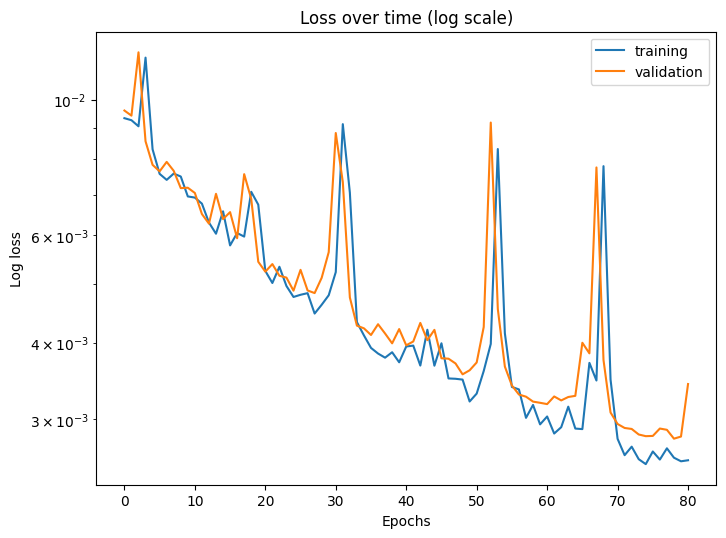

In [ ]:
"""
Train the model
Store training and validation loss and accuracy along the way
"""
epochs = 80
train_losses = []
val_losses = []
#initial val loss
val_loss = test_loss(val_loader, model)
val_losses.append(val_loss)
#initial training loss
train_loss = test_loss(train_loader, model)
train_losses.append([train_loss])
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    t_loss = train(train_loader, model, optimizer)
    train_losses.append(t_loss)
    v_loss = test_loss(val_loader, model)
    val_losses.append(v_loss)
print("Done!")
# PLOT LOSS
t_loss = np.ravel([l[0] for l in train_losses])
v_loss = np.ravel(val_losses)

#x scaling to plot diff sized arrays on same plot
x_t = np.linspace(0, epochs, len(t_loss))
x_v = np.linspace(0, epochs, len(v_loss))

print(t_loss)
print(x_t)

fig = plt.figure(figsize=(8, 6), dpi=100)
plt.plot(x_t, t_loss,label="training")
plt.plot(x_v, v_loss,label="validation")
plt.yscale("log")
plt.title("Loss over time (log scale)")
plt.ylabel("Log loss")
plt.xlabel("Epochs")
plt.legend()
plt.savefig('log_loss.png')
plt.show()

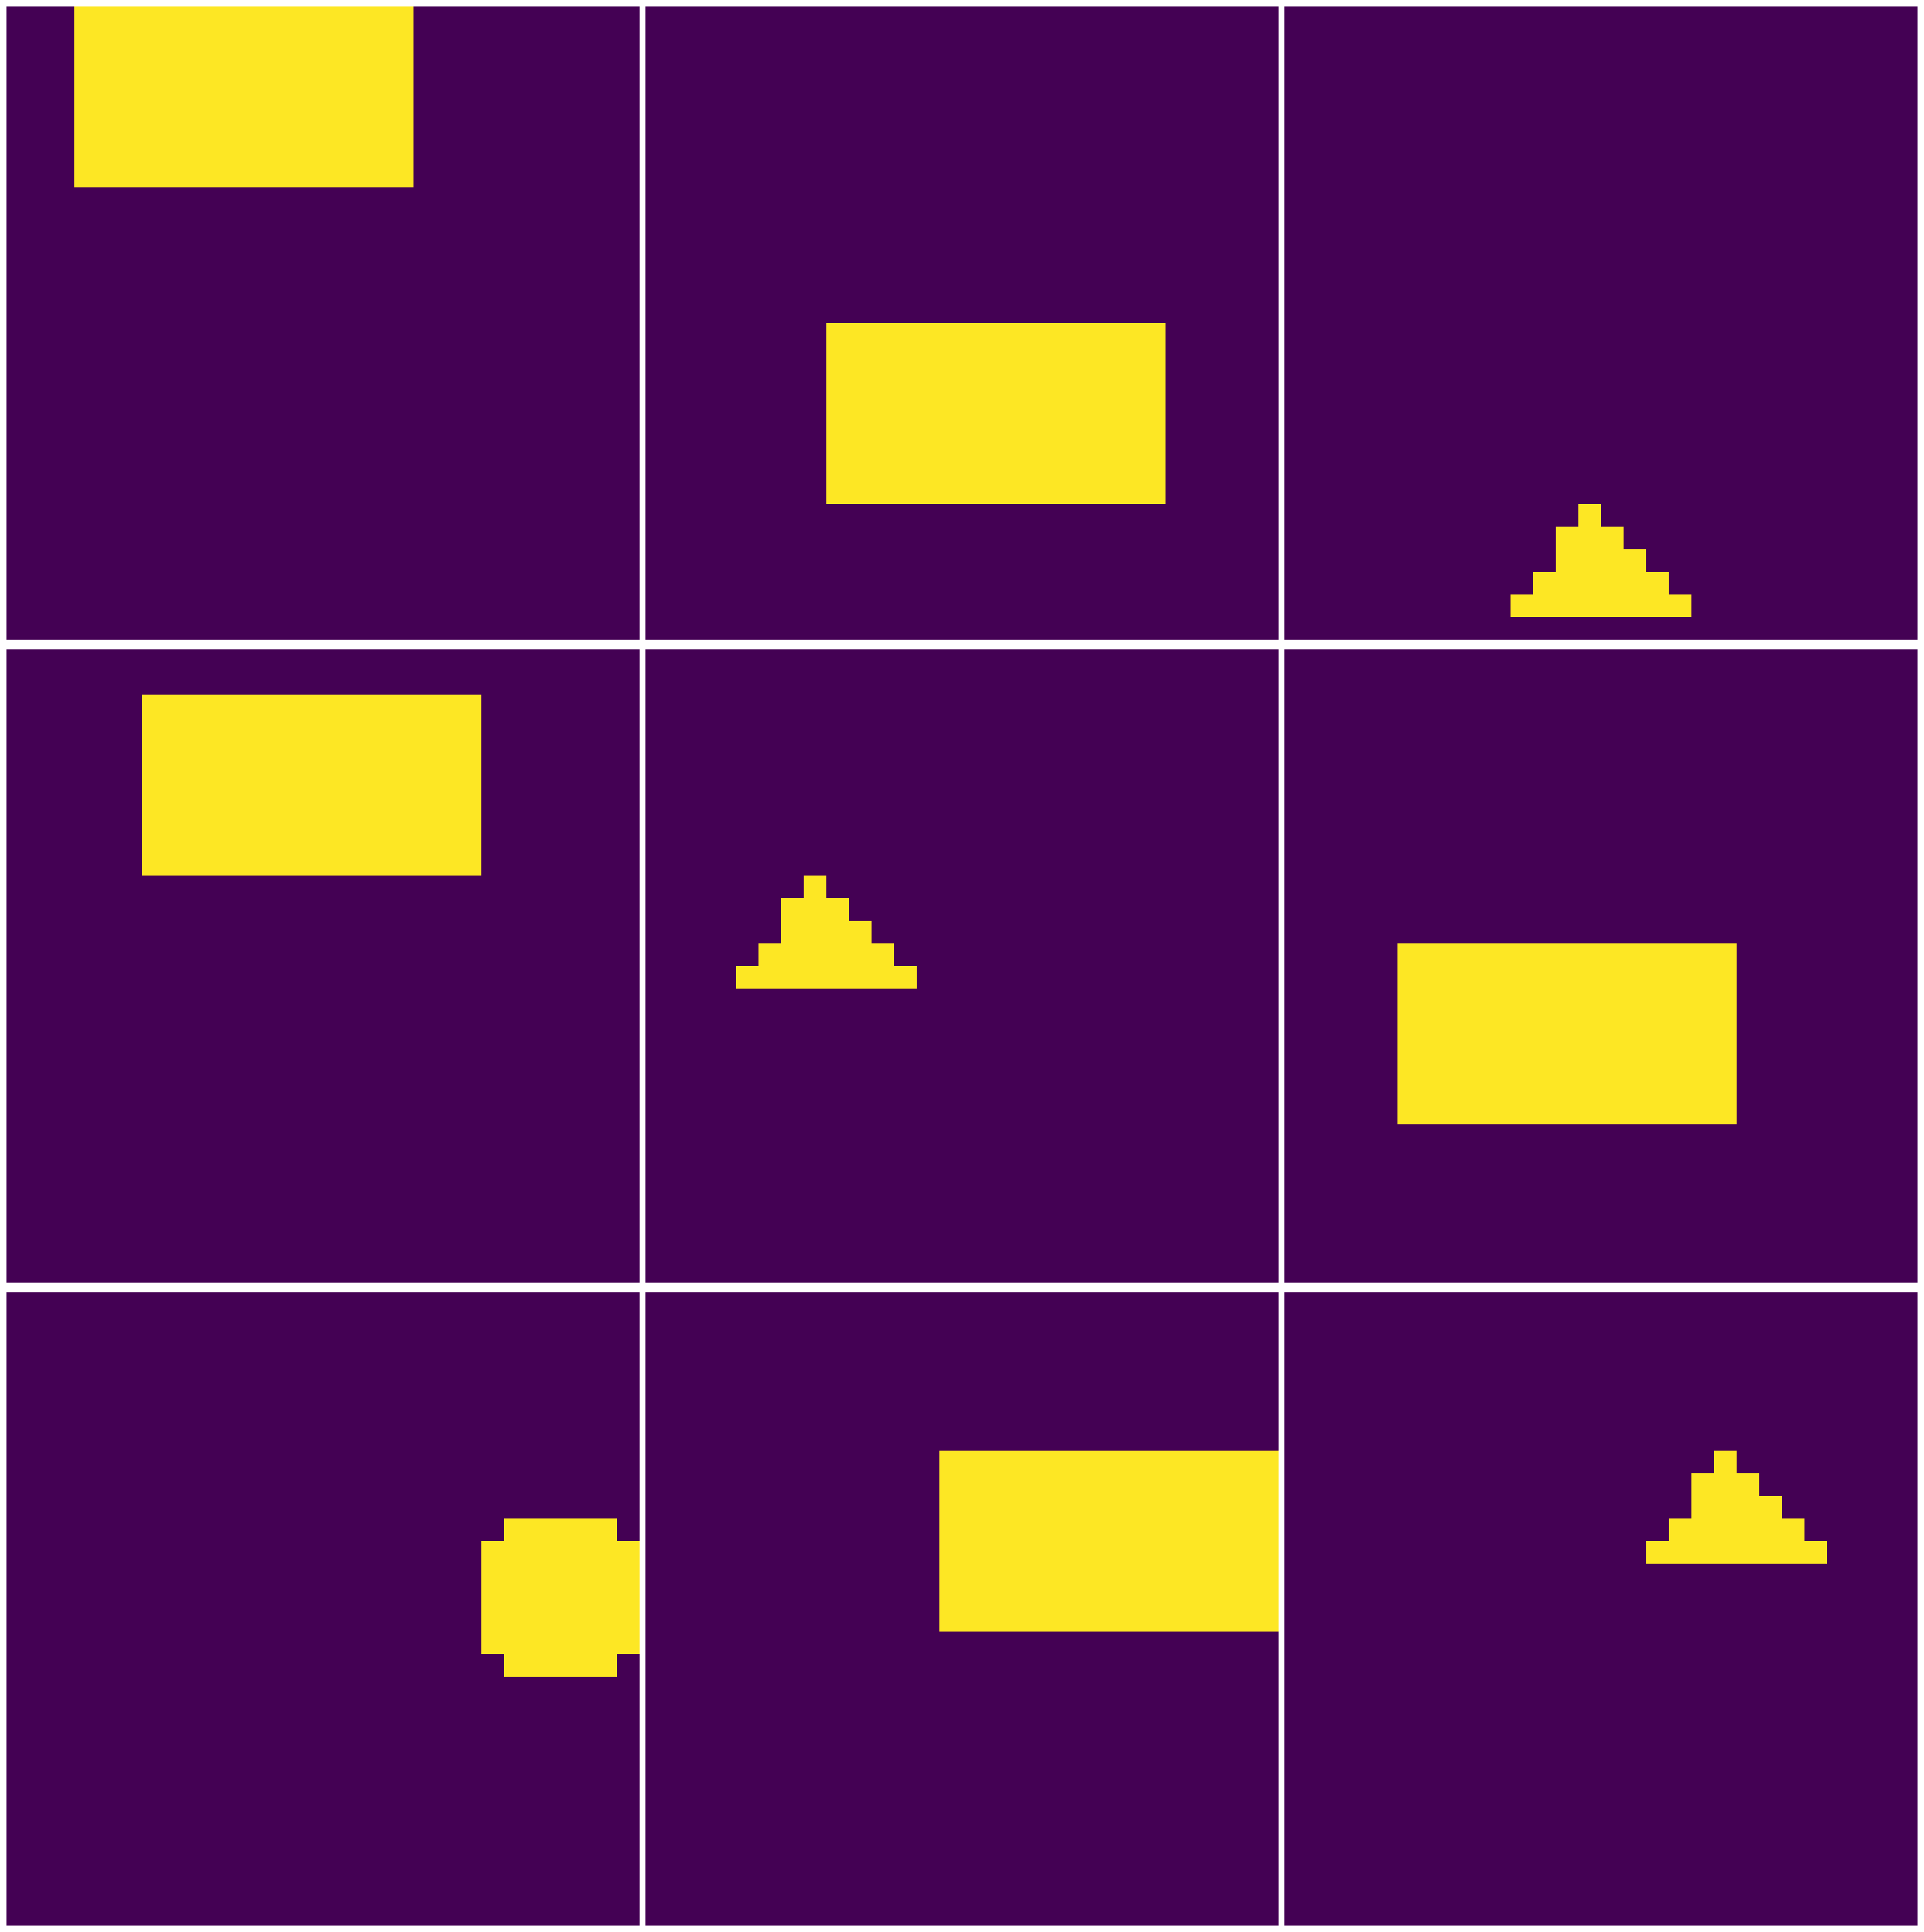

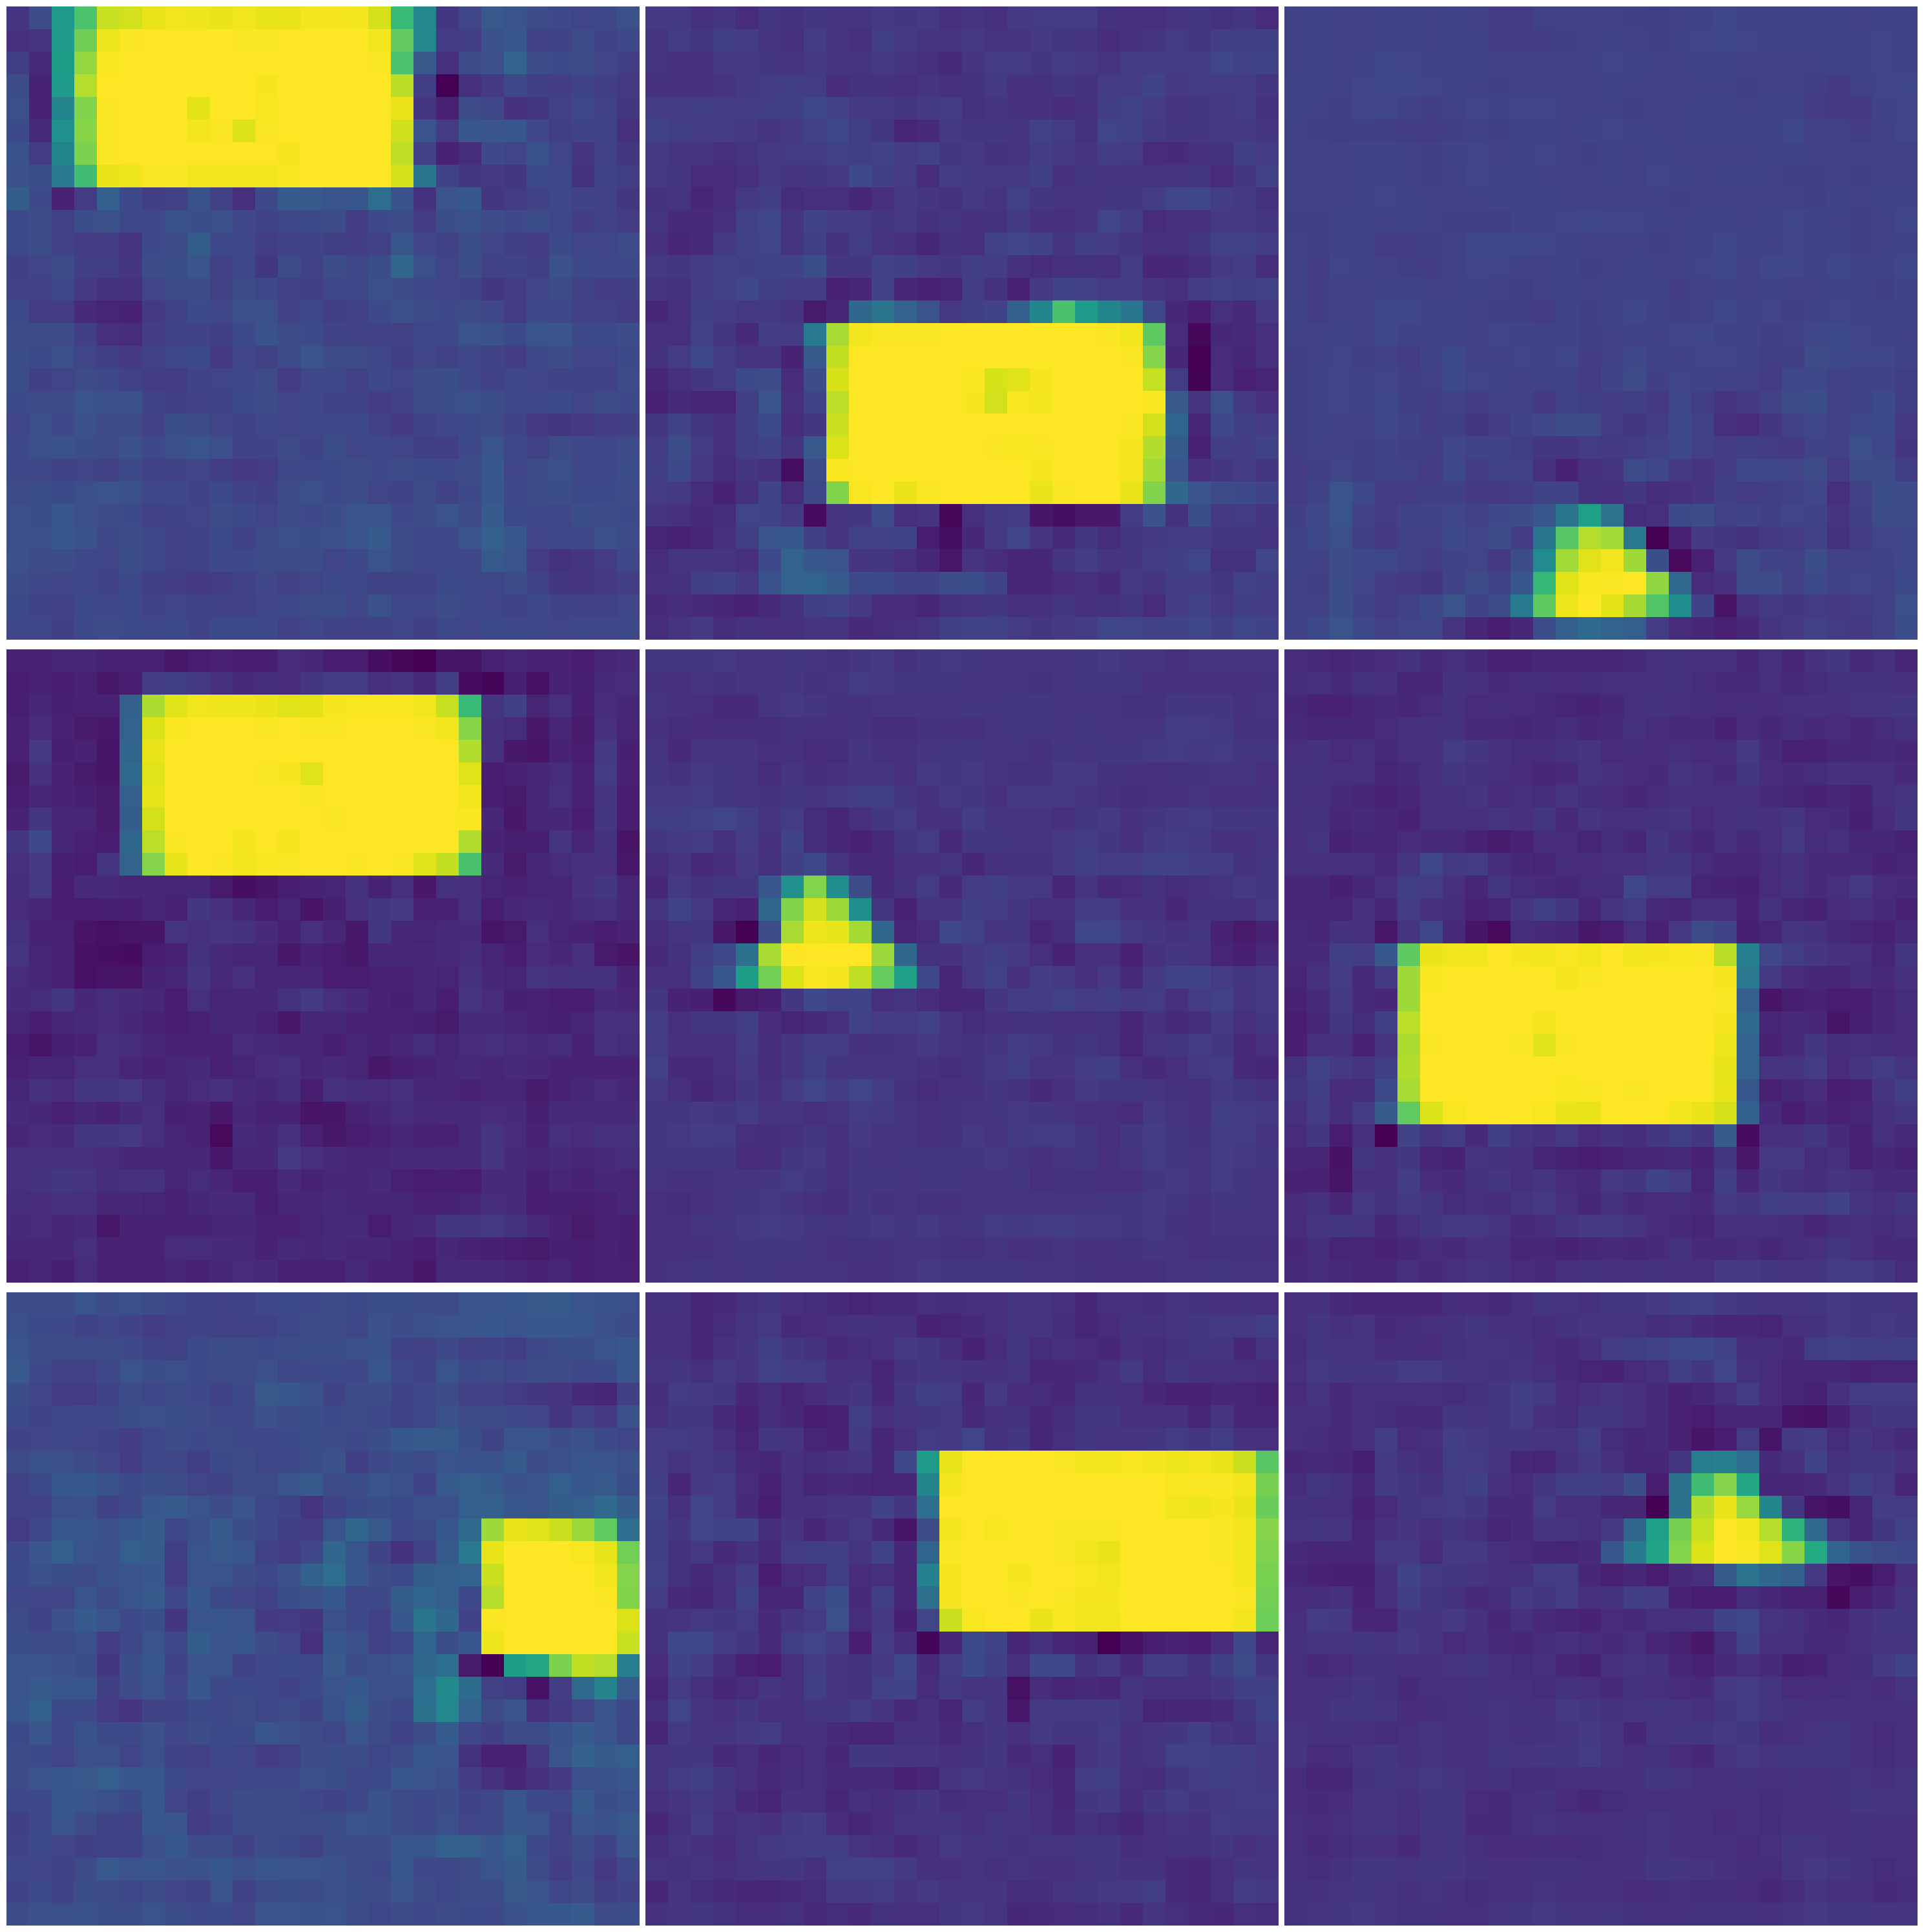

In [ ]:
# redo with batch size = 1 for easy plotting
test_dataset = datasets.ImageFolder(root='test_imgs', transform = transforms.ToTensor())
test_loader = data.DataLoader(test_dataset, batch_size = 1, shuffle = True)
size=3
cords=[
    [0,0],[0,1],[0,2],
    [1,0],[1,1],[1,2],
    [2,0],[2,1],[2,2]
]

preds = []

fig, ax_arr = plt.subplots(size, size, figsize=(30, 30), dpi=100)

# PLOT REAL IMAGES

model.eval()
with torch.no_grad():

    for batch, (x, y) in enumerate(test_loader):
        grid_spot = cords[batch]
        ax_cur = ax_arr[grid_spot[0],grid_spot[1]]
        x = x.squeeze()
        #just grab first shape
        x = x[(batch % 3),:,:].squeeze()
        ax_cur.imshow(x.reshape(28,28))
        ax_cur.axis('off')
        #our pred_dist is a weighting of how much it thinks each rotation is likely, 3 long
        x_hat, _, _ = model(x.to(device).view(-1,28*28))
        preds.append(x_hat)
        if batch == (size*size-1):
            break

    plt.axis('off')
    plt.tight_layout()
    plt.savefig(
        'original.png',
        bbox_inches='tight'
    )

    #PLOT RECONSTRUCTED IMAGES

    fig, ax_arr = plt.subplots(size, size, figsize=(30, 30), dpi=100)

    for i, x_hat in enumerate(preds):
        grid_spot = cords[i]
        ax_cur = ax_arr[grid_spot[0],grid_spot[1]]
        ax_cur.imshow(x_hat.cpu().numpy().reshape(28,28))
        ax_cur.axis('off')
    
    plt.axis('off')
    plt.tight_layout()
    plt.savefig('processed.png')
    plt.show()